# Pine & 8th St. Bioretention Notebook


In [7]:
#Load packages

import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues

In [35]:
#Import the res file, load the others
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
#locsumm = pd.read_excel('inputfiles/QuebecSt_TreeTrench.xlsx',index_col = 0)
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
#chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
pp = None
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/'
#res = pd.read_pickle(inpath+'outputspiketest1.pkl')
#res = pd.read_pickle(inpath+'wateryeartest.pkl')
res = pd.read_pickle(inpath+'20230112_SpikeTestCalibrated.pkl')
#res = pd.read_pickle(fpath+'/pickles/outputtest.pkl')
res.head()

x        dx  time    dm  maskts  maskss  porositywater  \
6PPDQ 240 0  0.012778  0.025556   0.0  True   False    True           0.42   
          1  0.038333  0.025556   0.0  True   False    True           0.42   
          2  0.063889  0.025556   0.0  True   False    True           0.42   
          3  0.089444  0.025556   0.0  True   False    True           0.42   
          4  0.115000  0.025556   0.0  True   False    True           0.42   

               Awater  Vsubsoil        V2  ...  M6_t1  a7_t1  M7_t1  a8_t1  \
6PPDQ 240 0  1.792707  0.511297  0.511297  ...    0.0    0.0    0.0    0.0   
          1  1.792707  0.511297  0.511297  ...    0.0    0.0    0.0    0.0   
          2  1.792707  0.511297  0.511297  ...    0.0    0.0    0.0    0.0   
          3  1.792707  0.511297  0.511297  ...    0.0    0.0    0.0    0.0   
          4  1.792707  0.511297  0.511297  ...    0.0    0.0    0.0    0.0   

             M8_t1  Mqin  Min_p  M_xf  M_n   dt  
6PPDQ 240 0    0.0   0.0    0.0   0.0  0.0  2.0  
          1    0.0   NaN    NaN   0.0  0.0  2.0  
          2    0.0   NaN    NaN   0.0  0.0  2.0  
          3    0.0   NaN    NaN   0.0  0.0  2.0  
          4    0.0   NaN    NaN   0.0  0.0  2.0  

[5 rows x 474 columns]

In [41]:
#Calculate the masses
#timeseries = pd.read_excel('inputfiles/2014_timeseries.xlsx')
timeseries = pd.read_excel('inputfiles/timeseries_wateryear.xlsx')
timeseries = timeseries.loc[timeseries.time<240,:]
indfactor = 1#3#3#'Load' #3#3
if indfactor == 'Load':
    timeseries = pd.read_pickle(pklpath+timedfname)
else:
    try: 
        int(indfactor) == indfactor
        timeseries = bc.modify_timestep(timeseries,indfactor)
    except TypeError:
        pass
#timeseries = timeseries[timeseries.time<=6]
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
mbal = bc.mass_balance(res,numc)
mbal_cum = bc.mass_balance_cumulative(numc, mass_balance = mbal,normalized=True)
mbal_cum.head()

time  Min  Mtot  Meff  Mexf  Minp  Minq  Mwater  Madvwater  \
6PPDQ 240  0.00  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      241  2.00  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      242  3.00  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      243  3.50  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      244  3.75  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   

           Mrwater  ...  Mnetshootspond  Mair  Madvair  Mrair  Mairpond  \
6PPDQ 240      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      241      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      242      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      243      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      244      NaN  ...             NaN   NaN      NaN    NaN       NaN   

           Mpondair  Mnetairpond  Mpond  Madvpond  Mrpond  
6PPDQ 240       NaN          NaN    NaN       NaN     NaN  
      241       NaN          NaN    NaN       NaN     NaN  
      242       NaN          NaN    NaN       NaN     NaN  
      243       NaN          NaN    NaN       NaN     NaN  
      244       NaN          NaN    NaN       NaN     NaN  

[5 rows x 119 columns]

In [222]:
res.loc[:,'c'] = res.v1*(res.dt)/res.dx
res[res.c>1]

x        dx      time    dm  maskts  maskss  \
6PPDQ     926 9   0.242778  0.025556  3.794444  True   False    True   
              10  0.268333  0.025556  3.794444  True   False    True   
              11  0.293889  0.025556  3.794444  True   False    True   
              12  0.319444  0.025556  3.794444  True   False    True   
              13  0.345000  0.025556  3.794444  True   False    True   
...                    ...       ...       ...   ...     ...     ...   
Rhodamine 929 13  0.345000  0.025556  3.833333  True   False    True   
              14  0.370556  0.025556  3.833333  True   False    True   
              15  0.396111  0.025556  3.833333  True   False    True   
              16  0.421667  0.025556  3.833333  True   False    True   
              17  0.447222  0.025556  3.833333  True   False    True   

                  porositywater    Awater  Vsubsoil        V2  ...  a7_t1  \
6PPDQ     926 9            0.42  1.792707  0.511297  0.511297  ...    0.0   
              10           0.42  1.792707  0.511297  0.511297  ...    0.0   
              11           0.42  1.792707  0.511297  0.511297  ...    0.0   
              12           0.42  1.792707  0.511297  0.511297  ...    0.0   
              13           0.42  1.792707  0.511297  0.511297  ...    0.0   
...                         ...       ...       ...       ...  ...    ...   
Rhodamine 929 13           0.42  1.792707  0.511297  0.511297  ...    0.0   
              14           0.42  1.792707  0.511297  0.511297  ...    0.0   
              15           0.42  1.792707  0.511297  0.511297  ...    0.0   
              16           0.42  1.792707  0.511297  0.511297  ...    0.0   
              17           0.42  1.792707  0.511297  0.511297  ...    0.0   

                  M7_t1  a8_t1  M8_t1  Mqin  Min_p          M_xf  \
6PPDQ     926 9     0.0    0.0    0.0   NaN    NaN  3.637046e-12   
              10    0.0    0.0    0.0   NaN    NaN  4.039063e-12   
              11    0.0    0.0    0.0   NaN    NaN  4.441478e-12   
              12    0.0    0.0    0.0   NaN    NaN  4.844242e-12   
              13    0.0    0.0    0.0   NaN    NaN  5.247303e-12   
...                 ...    ...    ...   ...    ...           ...   
Rhodamine 929 13    0.0    0.0    0.0   NaN    NaN  6.065491e-05   
              14    0.0    0.0    0.0   NaN    NaN  6.531429e-05   
              15    0.0    0.0    0.0   NaN    NaN  6.997599e-05   
              16    0.0    0.0    0.0   NaN    NaN  7.463945e-05   
              17    0.0    0.0    0.0   NaN    NaN  7.930413e-05   

                           M_n        dt         c  
6PPDQ     926 9   4.045568e-12  0.011111  1.002950  
              10  4.453300e-12  0.011111  1.015971  
              11  4.861387e-12  0.011111  1.028993  
              12  5.269779e-12  0.011111  1.042014  
              13  5.678424e-12  0.011111  1.055036  
...                        ...       ...       ...  
Rhodamine 929 13  6.609532e-05  0.016667  1.143767  
              14  7.085459e-05  0.016667  1.164188  
              15  7.561560e-05  0.016667  1.184609  
              16  8.037776e-05  0.016667  1.205030  
              17  8.514048e-05  0.016667  1.225451  

[63 rows x 475 columns]

In [54]:
flow_time.loc[(mask1.copy(),'pond'),'Q_in']

244  pond    0.000000
245  pond    0.142713
246  pond    0.285426
247  pond    0.428139
248  pond    0.570852
               ...   
949  pond    0.000000
950  pond    0.000000
951  pond    0.000000
952  pond    0.000000
953  pond    0.000000
Name: Q_in, Length: 710, dtype: float64

In [ ]:
#Plot the hydrology
hydro_name = 'flowtest.pkl'
flow_time = pd.read_pickle(inpath + hydro_name)
Qmeas = timeseries.loc[timeseries.time>=0,['time','Qout_meas']]
ylabel = 'Flow Rate (m³/h)'
xlabel = 'Time'
fig,ax = plt.subplots(1,2,figsize=(14,8),dpi=300,sharey=True)
#First event
comp = 'drain'
mask1 = (flow_time.time>=0) & (flow_time.time<6)
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[0].plot(flow_time.loc[(mask1,'drain'),'time'],Qmeas.loc[Qmeas.time<6,'Qout_meas'],'k') 
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),'pond'),'Q_in'],'#808080')
#Second Event
comp = 'drain'
mask2 = (flow_time.time>=143)
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[1].plot(flow_time.loc[(mask2,'drain'),'time'],Qmeas.loc[Qmeas.time>=143,'Qout_meas'],'k') 
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),'pond'),'Q_in'],'#808080')
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].set_ylim([0,10])
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
fig.savefig(fpath+'HydroFig.pdf', format='pdf',bbox_inches= 'tight')   

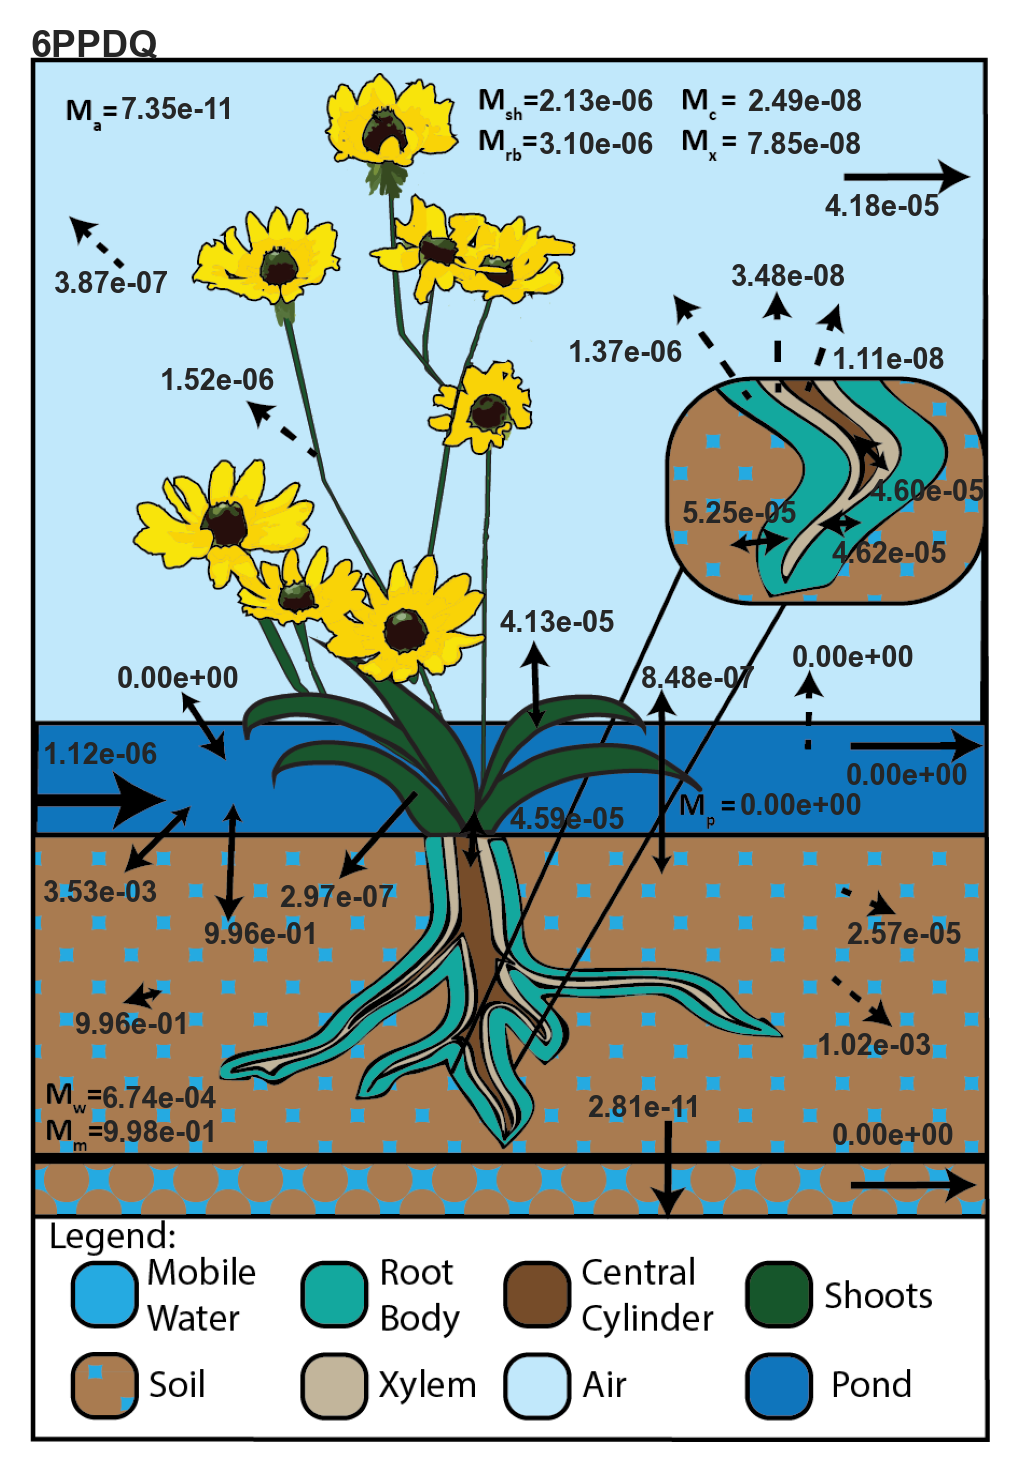

In [42]:
#Plot the fate diagram. Choose the compound and the time to display (in hours).
compound = '6PPDQ'#'Bromide'#use same name as in chemsumm
#Set time (hrs), any time after end gives the end.
time = 10000#6#1000#6#1000
fig,ax = bc.BC_fig(numc,mass_balance=mbal_cum,time = time,compound=compound,figheight=6,fontsize=7,dpi=300)
#Save the figure if you like. I save in pdf then edit in illustrator.
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'OutputModelFig_spiketest.pdf', format='pdf',bbox_inches= 'tight')  

In [14]:
Couts = bc.conc_out(numc,timeseries,chemsumm,res)
Couts.loc[:,'6PPDQ_Coutest'] = Couts.loc[:,'6PPDQ_Coutest'] *1e6 #ng/L
Couts.head()
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
Couts.head()

,time,Qout_meas,Qout,6PPDQ_Coutmeas,6PPDQ_Coutest,Bromide_Coutmeas,Bromide_Coutest,Rhodamine_Coutmeas,Rhodamine_Coutest
244,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


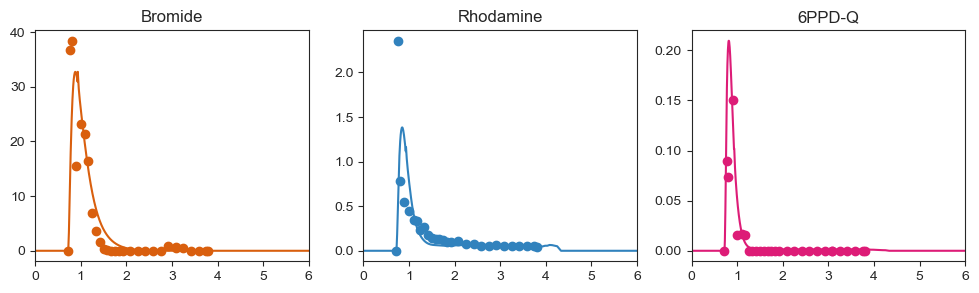

In [20]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,3,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
axs[0].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
axs[1].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Rhodamine_meas (mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
axs[0].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
axs[1].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
axs[2].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
axs[2].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['6PPDQ_Coutest']],color='#dd1c77')#dd1c77 #c994c7
axs[0].set_xlim((0,6))
axs[0].set_title('Bromide')
axs[1].set_title('Rhodamine')
axs[2].set_title('6PPD-Q')
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
fig.savefig(fpath+'testvsest_20230112.pdf', format='pdf',bbox_inches= 'tight')  

In [16]:
from hydroeval import kge #Kling-Gupta efficiency (Kling-Gupta et al., 2009)
import hydroeval
Couts2 = bc.conc_out(numc,timeseries,chemsumm,res)
KGE = {}
for ind,chem in enumerate(chemsumm.index):
    try:
        KGE[chem] = (hydroeval.evaluator(kge, np.array(Couts2.loc[:,chem+'_Coutest']),\
                          np.array(Couts2.loc[:,chem+'_Coutmeas'])))
    except KeyError:
        pass
KGE

{'6PPDQ': array([[0.11111702],
        [0.92683556],
        [1.48656729],
        [1.74027845]]),
 'Bromide': array([[0.83557735],
        [0.90648603],
        [1.03120514],
        [1.13159098]]),
 'Rhodamine': array([[0.71261024],
        [0.74228317],
        [1.12098759],
        [1.03920348]])}

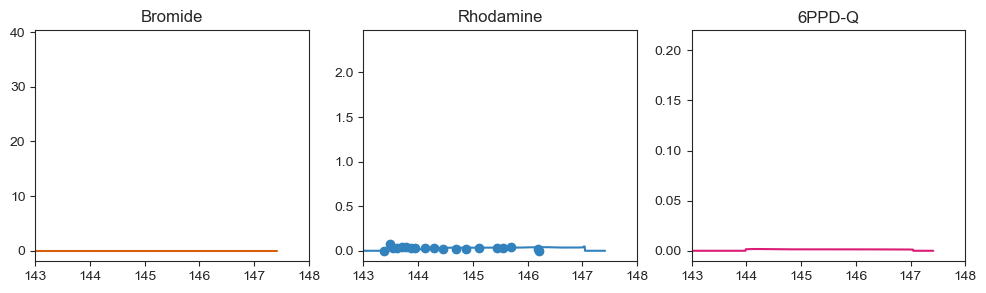

In [27]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,3,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
axs[0].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
axs[1].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Rhodamine_meas (mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
axs[0].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
axs[1].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
axs[2].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
axs[2].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['6PPDQ_Coutest']],color='#dd1c77')#dd1c77 #c994c7
axs[0].set_xlim((143,148))
axs[0].set_title('Bromide')
axs[1].set_title('Rhodamine')
axs[2].set_title('6PPD-Q')
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'testvsest_20230112.pdf', format='pdf',bbox_inches= 'tight')  

In [ ]:
mass_flux = bc.mass_flux(res,numc)
recovery = mass_flux.N_effluent.groupby(level=0).sum()/mass_flux.N_influent.groupby(level=0).sum()
recovery

In [ ]:
Couts2.loc[:,'dt']=Couts2.time.shift(-1)-Couts2.time
rec_meas={}
rec_meas['Bromide'] = (Couts2.Qout_meas*Couts2.loc[:,'Bromide_Coutmeas']*Couts2.dt).sum()/50.
rec_meas['Rhodamine'] = (Couts2.Qout_meas*Couts2.loc[:,'Rhodamine_Coutmeas']*Couts2.dt).sum()/3.126346839
rec_meas['6PPDQ'] = (Couts2.Qout_meas*Couts2.loc[:,'6PPDQ_Coutmeas']*Couts2.dt).sum()/8.47561E-07
rec_meas

In [ ]:
#Couts2

In [ ]:
#Couts2.loc[:,'dt']=Couts2.time.shift(-1)-Couts2.time
rec_est={}
rec_est['Bromide'] = (Couts2.Qout_meas*Couts2.loc[:,'Bromide_Coutest']*Couts2.dt).sum()/50.
rec_est['Rhodamine'] = (Couts2.Qout_meas*Couts2.loc[:,'Rhodamine_Coutest']*Couts2.dt).sum()/3.126346839
rec_est['6PPDQ'] = (Couts2.Qout_meas*Couts2.loc[:,'6PPDQ_Coutest']*Couts2.dt).sum()/8.47561E-07
rec_est

In [ ]:
flowpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/flowtest.pkl'
#flow_time = pd.read_pickle(flowpath)
bc.plot_flows(flow_time.loc[flow_time.time<6],Qmeas = timeseries.loc[(timeseries.time<6) & (timeseries.time>=0),'Qout_meas'],
                  compartments=['drain','water'],yvar='Q_todrain')
#timeseries.loc[timeseries.time<6,'time']
#timeseries.loc[(timeseries.time<6) & (timeseries.time>=0),'time']
#timeseries.loc[timeseries.time<6,'Qout_meas']
#pltdata = flow_time.loc[flow_time.time<6].Q_todrain

#pltdata.loc[(slice(None),['drain','water'])]
#ax = plt.plot(timeseries.loc[timeseries.time<6,'time'],timeseries.loc[timeseries.time<6,'Qout_meas'])

In [ ]:
#Try to incorporate SWMM
import pyswmm
from pyswmm import Simulation, RainGages
import pdb
swmmpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Data/Pine and 8th South - Bioretention Template/'
#swmmpath = 'C:/Users/trodge01/My Documents/EPA SWMM Projects/'
#sim = Simulation(swmmpath+'test3.inp')
#sim.close()
res = pd.DataFrame(columns = ['DateTime','Precip','Runoff'])
with Simulation(swmmpath+'pine8_catchmentonly.inp') as sim:
    pdb.set_trace()
    rg1 = RainGages(sim)["Gauge1"]
    subctch = pyswmm.Subcatchments(sim)["Roadway"]
    sim.end_time = datetime.datetime(2020, 1, 2, 0, 0)
    for ind,step in enumerate(sim):
        res.loc[ind,'DateTime'] = sim.current_time
        res.loc[ind,'Precip'] = rg1.total_precip
        res.loc[ind,'Runoff'] = subctch.runoff
        #pdb.set_trace()
        #rg1.total_precip = 1.0 #mm/hr
        #print()
        #print(rg1.total_precip)
        #print(subctch.runoff)
        pass
res
    #sim.execute()
    #sim.report()
res.Runo

In [ ]:
#full_series = pd.read_excel('inputfiles/2014_timeseries.xlsx')
SWMMseries = full_series[:5000]
#ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60])
#len(ramp) - 1
t = 2470
dt = 6
SWMMend = int(dt *60)-1
np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
#SWMMseries.loc[t:t+SWMMend,'Precip']
#timeseries.loc[:,'r_shift'] = timeseries.Runoff.shift(-1*60)
#timeseries.loc[t:t+60,'r_shift']

In [ ]:
#Run to get swmm outputs from full-year timeseries
full_series = pd.read_excel('inputfiles/2014_timeseries.xlsx')
#SWMMseries.head()
timeseries = pd.DataFrame(columns = ['elapsedtime','precip','runoff'])
ind = 0
SWMMseries = full_series[:5000]
SWMMseries.loc[:,'p_shift'] = SWMMseries.Precip.shift(15*60)#Start changing X hrs before precipitation
#Chose 15 hrs to give 6,3,2,1,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60
SWMMseries.loc[:,'r_shift'] = SWMMseries.Runoff.shift(1*60)#Start changing X hrs after Qin ends
pswitch = False #To ramp up
rswitch = True #To ramp down. Start true.
ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60])
rampstep = 0
dt = 6.0 #Hours. Baseline is 6 hours in dry periods, 1 minute in wet periods
while t < len(SWMMseries.index):
    pdb.set_trace()
    if pswitch == True: #Ramp timestep down to 1 minute and stay there until rswitch activates
        rampstep = ramp + 1
        if rampstep >= len(ramp):#stay at 1/60 if there
            rampstep = len(ramp)-1       
        #Start to ramp up to 6 hrs if the next X minutes all have zero flow. 
        if  (rswitch == False) & (SWMMseries.loc[t:t+60,'r_shift'] != 0):
            rswitch = True
            pswitch = False
            
    elif rswitch == True:
        rampstep = rampstep - 1
        if rampstep < 0:#stay at 6 hrs if there
            rampstep = 0 
        #Start to ramp down to 1 minute when precipitation appears
        if (pswitch == False) & (SWMMseries.loc[t,'p_shift'] != 0):
            pswitch = True
            rswitch = False
            rampstep = 0
    #Now, we are going to make the timeseries for the BC Blues model 
    #Each timestep represents the average from t to t + dt (not including the last step)
    #Elapsed time at the beginning of the timestep (hrs)
    timeseries.loc[ind,'elapsedtime'] += dt
    #Then, change dt
    dt = ramp[rampstep]
    #Next, add the accumulated precipitation and runoff across the timestep
    SWMMend = ind(dt *60)-1 #Averaging period
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
    #To finish, we will go to the next t based on dt
    t += int(dt*60)
    ind += 1
    #Ramp up to 1 minute from 6 hours when pswitch triggers

        
    

In [207]:
#full_series = pd.read_excel('inputfiles/wateryear_timeseries.xlsx')
#SWMMseries.head()
timeseries = pd.DataFrame(columns = ['dt','elapsedtime','precip','runoff'])
ind = 0
#pdb.set_trace()
timeseries.loc[ind,:] = 0.
SWMMseries = full_series#[:5000]
p_shift = 10*60 #Start changing timestep X hrs before precipitation
r_shift = 1*60 #Start changing timestep X hrs after Qin ends
SWMMseries.loc[:,'p_shift'] = SWMMseries.Precip.shift(-15*60)#Start changing X hrs before precipitation
#Chose 15 hrs to give 6,3,2,1,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60
#SWMMseries.loc[:,'r_shift'] = SWMMseries.Runoff.shift(-1*60)#Start changing X hrs after Qin ends
pswitch = False #To ramp up
rswitch = True #To ramp down. Start true.
ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.25,10/60,5/60,1/60])
rampstep = 3
dt = 3.0 #Hours. Baseline is 6 hours in dry periods, 1 minute in wet periods
t = 0
while t < len(SWMMseries.index):
    #pdb.set_trace()
    if pswitch == True: #Ramp timestep down to 1 minute and stay there until rswitch activates
        rampstep = rampstep + 1
        if rampstep >= len(ramp):#stay at 1/60 if there
            rampstep = len(ramp)-1       
        #Start to ramp up to 6 hrs if the next X minutes all have zero flow & Y mins have 0 precipitation 
        if  (rswitch == False) & (SWMMseries.loc[t:t+r_shift,'Runoff'].sum() == 0)& (SWMMseries.loc[t:t+p_shift,'Precip'].sum() == 0):
            rswitch = True
            pswitch = False
            
    elif rswitch == True:
        rampstep = rampstep - 1
        if rampstep < 0:#stay at 6 hrs if there
            rampstep = 0 
        #Start to ramp down to 1 minute when precipitation appears
        if (pswitch == False) & (SWMMseries.loc[t:t+p_shift,'Precip'].sum() != 0):
            pswitch = True
            rswitch = False
            #rampstep = 0
    #Now, we are going to make the timeseries for the BC Blues model 
    #Each timestep represents the average from t to t + dt (not including the last step)
    #Elapsed time at the beginning of the timestep (hrs)
    #timeseries.loc[ind,'elapsedtime'] += dt
    #Then, change dt
    dt = ramp[rampstep]
    timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
    #Next, add the accumulated precipitation and runoff across the timestep
    SWMMend = int(dt *60)-1 #Averaging period
    timeseries.loc[ind,'dt'] = dt
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
    timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h
    while (dt > ramp[-1]) & (timeseries.loc[ind,'runoff'] > 0):
        rampstep = rampstep +1
        dt = ramp[rampstep]
        timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
        #Next, add the accumulated precipitation and runoff across the timestep
        SWMMend = int(dt *60)-1 #Averaging period
        timeseries.loc[ind,'dt'] = dt
        timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
        timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h    
    #To finish, we will go to the next t based on dt
    t += int(dt*60)
    ind += 1
    #Ramp up to 1 minute from 6 hours when pswitch triggers
#timeseries.loc[0,'dt'] = 6
timeseries = timeseries.drop(index=max(timeseries.index))
#timeseries[:25]
#timeseries.to_excel('inputfiles/swmmouts_2014.xlsx')
timeseries.to_excel('inputfiles/swmmouts_wateryear.xlsx')

In [211]:
timeseries.to_excel('inputfiles/swmmouts_wateryear.xlsx')

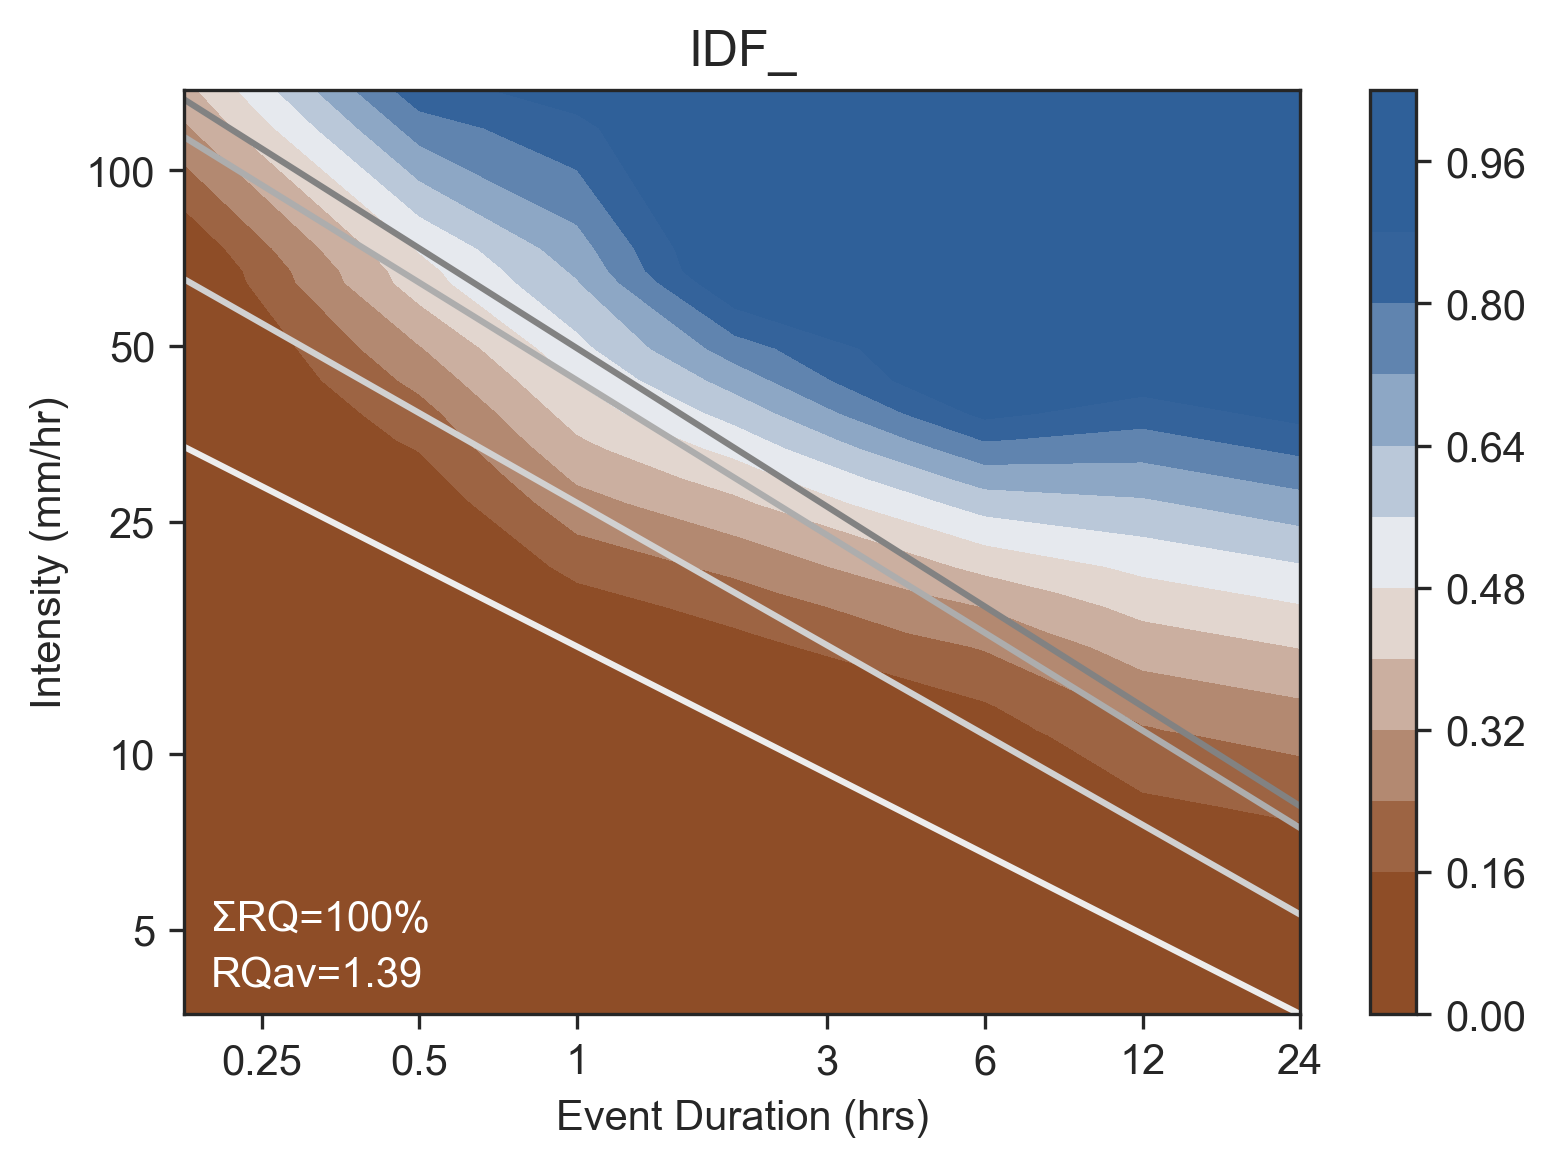

In [36]:
#Plot system performance on IDF curves. This plots the actual values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
#defname = ['IDF_defaults.pkl']
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)

#scenarios = ['defaults','fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
combos = ((0,0,0,0,0,0),)#,(0,0,0,1,0,0),(1,1,0,0,1,0),(1,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+str(scenario)+'.pkl'
    #testname = 'IDF_defaults'
    pltdata = pd.read_pickle(inpath+testname)
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    interplims = [0.,1.]
    #interplims = [0.,3.5]
    vlims = [0.15,0.85]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    cmap = None
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'w')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'w')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [ ]:
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_defaults.pkl'
defdata = pd.read_pickle(inpath+defname)

In [ ]:
defdata.RQ_sum.sum()

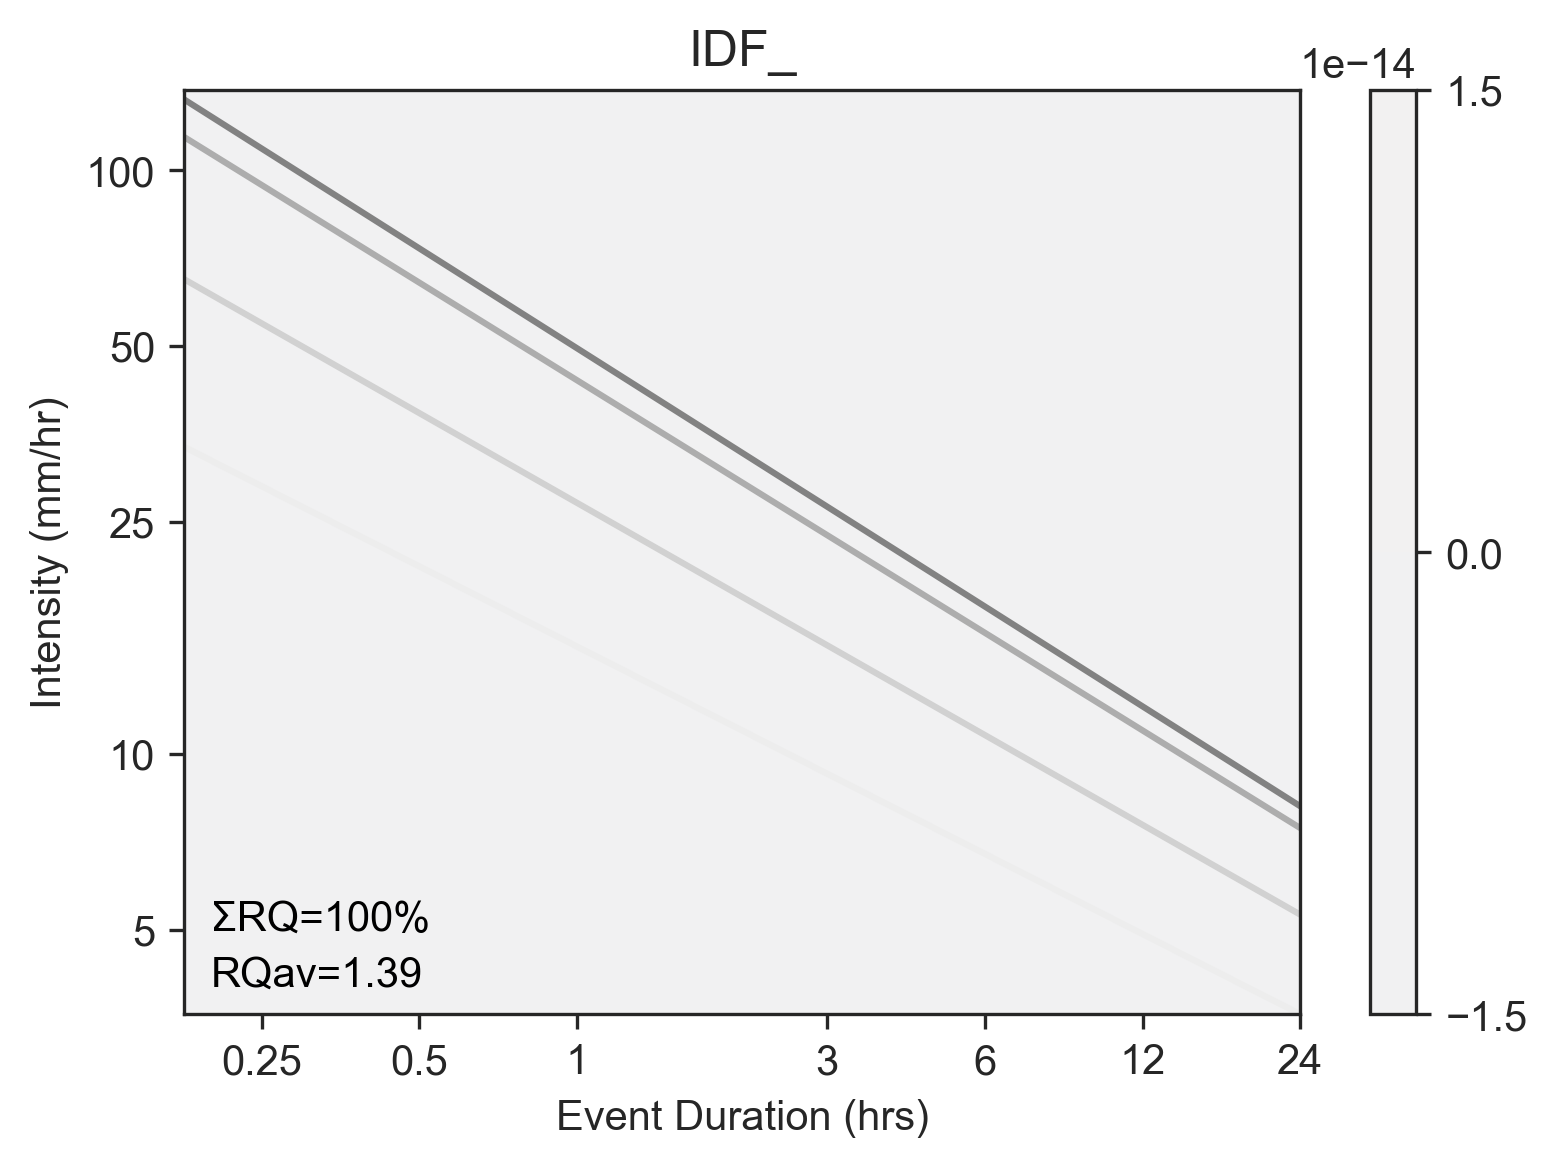

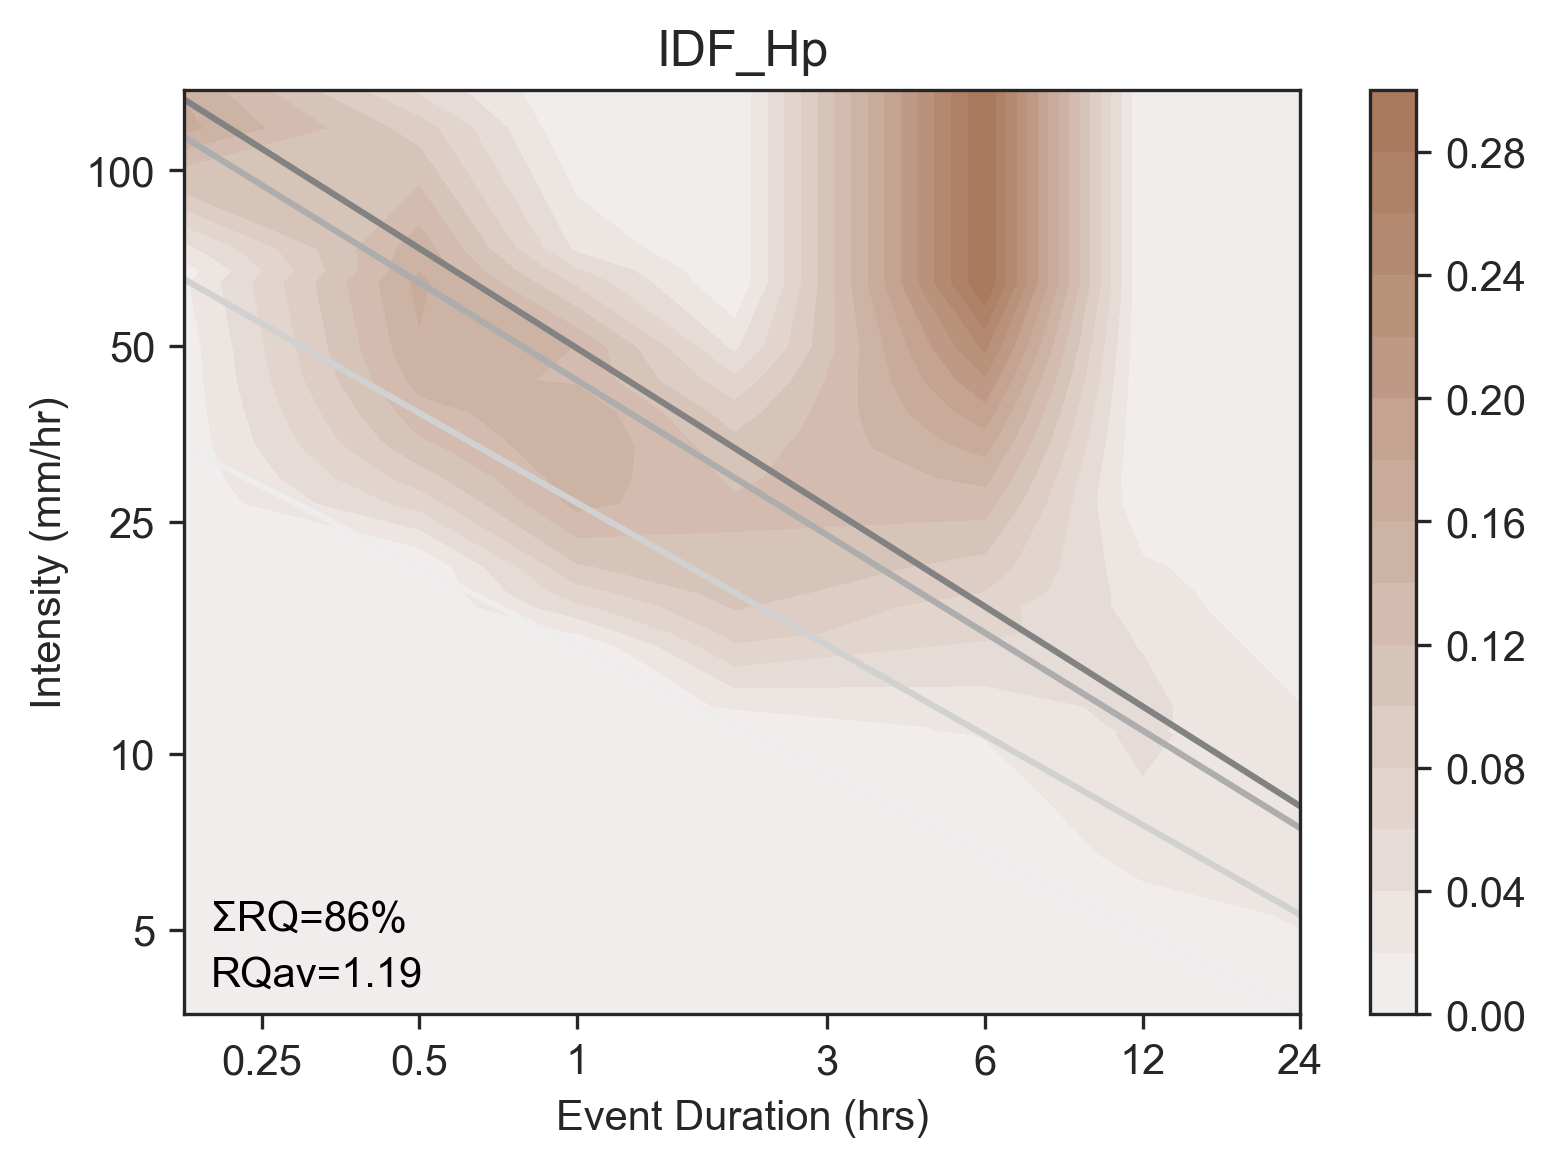

In [37]:
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
#combos = ((0,0,0,0,0,0),(1,0,0,0,0,0),(0,1,0,0,0,0),(0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=6))
#combos = combos[:38]
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    pltvars_delta = pltvars.copy()
    delname = pltvars[0] +'_delta'
    pltvars_delta[0] = delname
    pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] - pltdata.loc[:,pltvars[0]]
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    hilim = np.round(2*max(pltdata.loc[:,delname]),decimals=1)
    lolim = np.round(2*min(pltdata.loc[:,delname]),decimals=1)
    interplims = [lolim,hilim]
    #interplims = [0.,3.5]
    vlims = [-0.4,0.4]
    #vlims = [lolim,hilim]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    #cmap = None
    #if lolim<0:
    #    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
    #else: 
    #    cmap = sns.light_palette('#8f4e27', as_cmap=True)
    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
        #cmap = sns.light_palette("seagreen", as_cmap=True)
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_delta_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'k')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    #fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [40]:
#Find best scenarios
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
#combos = ((0,0,0,0,0,0),(1,0,0,0,0,0),(0,1,0,0,0,0),(0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=6))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]

,RQ_sum,RQ_av
Asys,0.313416,0.545149
Hp,0.864861,1.189537
,1.0,1.390502


In [51]:
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]

,RQ_sum,RQ_av
Foc_Asys_Hp,0.015004,0.040453
Asys_Hp,0.015004,0.040453
fvalve_Foc_Asys_Hp,0.015135,0.040836
fvalve_Asys_Hp,0.015135,0.040836
Foc_Dsys_Asys_Hp,0.022867,0.062561
Dsys_Asys_Hp,0.022867,0.062561
fvalve_Foc_Dsys_Asys_Hp,0.023934,0.065802
fvalve_Dsys_Asys_Hp,0.023934,0.065802
Foc_Asys,0.121826,0.249636
Asys,0.121826,0.249636
